# 감성 분석

* 문서의 주관적인 감성/의견/감정/기분 등을 파악하기 위한 방법
* 쇼셜 미디어, 여론조사, 온라인 리뷰, 피드백 등 다양한 분야에서 활용되고 있다.
* 감성 분석은 문서 내 텍스트가 나타내는 여러 가지 주관적인 단어와 문맥을 기반으로 감성(Sentiment) 수치를 계산하는 방법을 이용.
* 긍정 / 부정 지수로 구성 -> 합산하여 긍/부정 결정
* 지도 학습 : 학습 데이터와 타깃 레이블 값을 기반으로 학습 수행. 이를 기반으로 다른 데이터의 감성 분석을 예측하는 방법 => 텍스트 기반의 분류와 거의 유사
* 비지도 학습 : 'Lexicon'이라는 감성 어휘 사전 이용. 감성 분석을 위한 용어와 문맥에 대한 정보를 갖고 긍/부정적 감성 여부 판단.

### 지도학습 기반 감성 분석 - IMDB 영화평
* https://www.kaggle.com/c/word2vec-nlp-tutorial/data


In [1]:
import pandas as pd

review_df = pd.read_csv('/content/drive/MyDrive/파이썬_머신러닝_완벽가이드/08_Text_Analytics/labeledTrainData.tsv', header=0, sep='\t', quoting=3)
review_df.head(3)

,id,sentiment,review
0,"""5814_8""",1,"""With all this stuff going down at the moment ..."
1,"""2381_9""",1,"""\""The Classic War of the Worlds\"" by Timothy ..."
2,"""7759_3""",0,"""The film starts with a manager (Nicholas Bell..."


* id : 각 데이터의 id
* sentiment : 영화평(review)의 Sentiment 결과값(Target Label). 1은 긍정, 0은 부정
* review : 영화평


In [2]:
review_df['review'][0]

'"With all this stuff going down at the moment with MJ i\'ve started listening to his music, watching the odd documentary here and there, watched The Wiz and watched Moonwalker again. Maybe i just want to get a certain insight into this guy who i thought was really cool in the eighties just to maybe make up my mind whether he is guilty or innocent. Moonwalker is part biography, part feature film which i remember going to see at the cinema when it was originally released. Some of it has subtle messages about MJ\'s feeling towards the press and also the obvious message of drugs are bad m\'kay.<br /><br />Visually impressive but of course this is all about Michael Jackson so unless you remotely like MJ in anyway then you are going to hate this and find it boring. Some may call MJ an egotist for consenting to the making of this movie BUT MJ and most of his fans would say that he made it for the fans which if true is really nice of him.<br /><br />The actual feature film bit when it finally

HTML 형식에서 추출해 태그가 존재한다. 그래서 태그를 피처로 만들 필요가 없다. replace()로 태그를 공백으로 바꾼다.

In [3]:
import re

# <br> html 태그는 replace 함수로 공백으로 변환
review_df['review'] = review_df['review'].str.replace('<br />', ' ')

# 파이썬 정규 표현식 모듈인 re를 이용해 영어 문자열이 아닌 문자는 모두 공백으로 변환
review_df['review'] = review_df['review'].apply(lambda x: re.sub("[^a-zA-Z]", " ", x))

In [4]:
# 결정값 클래스인 sentiment 칼럼을 별도로 추출해 결정 값 데이터 세트를 만들고
# 원본 데이터 세트에서 id와 sentiment 칼럼을 삭제해 피처 데이터 세트르 생성
from sklearn.model_selection import train_test_split

class_df = review_df['sentiment']
feature_df = review_df.drop(['id', 'sentiment'], axis=1, inplace=False)

X_train, X_test, y_train, y_test = train_test_split(feature_df, class_df, test_size=0.3, random_state=156)
X_train.shape, X_test.shape

((17500, 1), (7500, 1))

In [5]:
# Count 벡터화, TF-IDF 벡터화를 각각 적용해 예측 성능 측정
# Classifier는 LogisticRegression 이용
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score

In [6]:
# Count 벡터화
# 스톱 워드는 English, filtering, ngram은 (1, 2)로 설정해 CountVectorization 수행
# LogisticRegression의 C는 10으로 설정
pipeline = Pipeline([
    ('cnt_vect', CountVectorizer(stop_words='english', ngram_range=(1,2) )),
    ('lr_clf', LogisticRegression(C=10, solver='lbfgs', max_iter=1000))])

# Pipeline 객체를 이용하여 fit(), predict()로 학습/예측 수행. 
# predict_proba()는 roc_auc때문에 수행.  
pipeline.fit(X_train['review'], y_train)
pred = pipeline.predict(X_test['review'])
pred_probs = pipeline.predict_proba(X_test['review'])[:,1]

print('예측 정확도는 {0:.4f}, ROC-AUC는 {1:.4f}'.format(accuracy_score(y_test ,pred),
                                         roc_auc_score(y_test, pred_probs)))

예측 정확도는 0.8860, ROC-AUC는 0.9503


In [7]:
# TF-IDF 벡터화
# 스톱 워드는 English, filtering, ngram은 (1, 2)로 설정해 TF-IDF 벡터화 수행
# LogisticRegression의 C는 10으로 설정
pipeline = Pipeline([
    ('tfidf_vect', TfidfVectorizer(stop_words='english', ngram_range=(1, 2))),
     ('lr_clf', LogisticRegression(C=10, solver='lbfgs', max_iter=1000))])

pipeline.fit(X_train['review'], y_train)
pred = pipeline.predict(X_test['review'])
pred_probs  = pipeline.predict_proba(X_test['review'])[:, 1]

print('예측 정확도는 {0:.4f}, ROC-AUC는 {1:.4f}'.format(accuracy_score(y_test ,pred),
                                         roc_auc_score(y_test, pred_probs)))

예측 정확도는 0.8936, ROC-AUC는 0.9598


### 비지도학습 기반 감성 분석 소개

* Lexicon 기반 : 금정/부정 감성의 정도를 의미하는 수치(감성 지수)를 가짐
* 감성 지수는 단어의 위치나 주변 단어, 문맥, POS(Part of Speech) 등을 참고해 결정
* NLTK.WordNet : 어휘의 시맨틱(문맥상 의미) 분석을 제공. 각각의 품사(명사, 동사, 형용사, 부사 등)로 구성된 개별 단어를 Synset이라는 개념을 이용해 표현
* NLTK 감성 사전의 예측 성능이 좋지 않아 일반적으로 다른 감성 사전 적용
    * SentiWordNet : 긍/부정 감성 지수, 객관성 지수를 할당하여 최종 감성 지수를 계산. 이를 기반해 긍/부정 결정
    * VADER : 주로 소셜 미디어의 텍스트에 대한 감성 분석을 제공. 비교적 빠른 시간에 뛰어난 분석 결과를 제공하여 대용량 데이터에 해당됨
    * Pattern : 예측 성능 측면에서 뛰어남.

In [8]:
# SentiWordNet을 이용한 감성 분석
import nltk
nltk.download('all')

[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to /root/nltk_data...
[nltk_data]    |   Package abc is already up-to-date!
[nltk_data]    | Downloading package alpino to /root/nltk_data...
[nltk_data]    |   Package alpino is already up-to-date!
[nltk_data]    | Downloading package biocreative_ppi to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Package biocreative_ppi is already up-to-date!
[nltk_data]    | Downloading package brown to /root/nltk_data...
[nltk_data]    |   Package brown is already up-to-date!
[nltk_data]    | Downloading package brown_tei to /root/nltk_data...
[nltk_data]    |   Package brown_tei is already up-to-date!
[nltk_data]    | Downloading package cess_cat to /root/nltk_data...
[nltk_data]    |   Package cess_cat is already up-to-date!
[nltk_data]    | Downloading package cess_esp to /root/nltk_data...
[nltk_data]    |   Package cess_esp is already up-to-date!
[nltk_data]    | Downloading packag

True

In [9]:
# WordNet 모듈을 임포드해서 'present' 단어에 대한 Synset을 추출.
# WordNet의 Synset()는 파라미터로 지정된 단어에 대해 WordNEt에 등재된 모든 Synset 객체를 반환.
from nltk.corpus import wordnet as wn

term = 'present'

synsets = wn.synsets(term)
print('synsets() 반환 type :', type(synsets))
print('synsets() 반환 값 개수 :', len(synsets))
print('synsets() 반환 값 :', synsets)

synsets() 반환 type : <class 'list'>
synsets() 반환 값 개수 : 18
synsets() 반환 값 : [Synset('present.n.01'), Synset('present.n.02'), Synset('present.n.03'), Synset('show.v.01'), Synset('present.v.02'), Synset('stage.v.01'), Synset('present.v.04'), Synset('present.v.05'), Synset('award.v.01'), Synset('give.v.08'), Synset('deliver.v.01'), Synset('introduce.v.01'), Synset('portray.v.04'), Synset('confront.v.03'), Synset('present.v.12'), Synset('salute.v.06'), Synset('present.a.01'), Synset('present.a.02')]


synsets() 호출 시 반환되는 것은 여러 개의 Synset 객체를 가지는 리스트이다. 총 18개의 서로 다른 sementic을 가지는 synset 객체가 반환되었다. Synset('present.n.01')와 같이 Synset 객체의 파라미터 'present.n.01'은 POS 태그를 나타낸다.

'present.n.01'에서 present는 의미, n은 명사 품사, 01은 present가 명사로서 가지는 의미가 여러가지 있어서 이를 구분하는 인덱스.

In [10]:
# synset 객체가 가지는 여러가지 속성
# 정의(Definition), 부명제(Lemma) 등으로 시맨틱적 요소 표현
for synset in synsets:
    print('##### Synset name :', synset.name(), '#####')
    print('POS :', synset.lexname())
    print('Definition :', synset.definition())
    print('Lemma :', synset.lemma_names())

##### Synset name : present.n.01 #####
POS : noun.time
Definition : the period of time that is happening now; any continuous stretch of time including the moment of speech
Lemma : ['present', 'nowadays']
##### Synset name : present.n.02 #####
POS : noun.possession
Definition : something presented as a gift
Lemma : ['present']
##### Synset name : present.n.03 #####
POS : noun.communication
Definition : a verb tense that expresses actions or states at the time of speaking
Lemma : ['present', 'present_tense']
##### Synset name : show.v.01 #####
POS : verb.perception
Definition : give an exhibition of to an interested audience
Lemma : ['show', 'demo', 'exhibit', 'present', 'demonstrate']
##### Synset name : present.v.02 #####
POS : verb.communication
Definition : bring forward and present to the mind
Lemma : ['present', 'represent', 'lay_out']
##### Synset name : stage.v.01 #####
POS : verb.creation
Definition : perform (a play), especially on a stage
Lemma : ['stage', 'present', 'represen

* Synset('present.n.01')과 Synset('Present.n.02')는 명사지만 서로 다른 의미를 가진다.
* Synset('present.n.01')은 POS가 noun.time이며 Definition을 살펴보면 '시간적인 의미로 현재'를 의미.
* Synset('Present.n.02')은 POS가 noun.possession이며 Definition은 '선물'이다.

WordNet은 어떤 어휘와 다른 어휘 간의 관계를 유사도로 나타낼 수 있다. synset 객체는 단어 간의 유사도를 나타내기 위해서 path_similarity() 메서드 제공.


In [11]:
# synset 객체를 단어별로 생성합니다. 
tree = wn.synset('tree.n.01')
lion = wn.synset('lion.n.01')
tiger = wn.synset('tiger.n.02')
cat = wn.synset('cat.n.01')
dog = wn.synset('dog.n.01')

entities = [tree, lion, tiger, cat, dog]
similarities = []
entity_names = [entity.name().split('.')[0] for entity in entities]

# 단어별 synset을 반복하면서 다른 단어의 synset과 유사도 측정
for entity in entities:
    similarity = [round(entity.path_similarity(compared_entity), 2) for compared_entity in entities]
    similarities.append(similarity)

# 개별 단어별 synset과 다른 언어의 synset과의 유사도를 DataFrame 형태로 저장
similarity_df = pd.DataFrame(similarities, columns=entity_names, index=entity_names)
similarity_df

,tree,lion,tiger,cat,dog
tree,1.00,0.07,0.07,0.08,0.12
lion,0.07,1.00,0.33,0.25,0.17
tiger,0.07,0.33,1.00,0.25,0.17
cat,0.08,0.25,0.25,1.00,0.20
dog,0.12,0.17,0.17,0.20,1.00


lion은 tree와의 유사도가 0.07로 가장 적고, tiger와는 유사도가 0.33으로 가장 큼.

In [12]:
import nltk
from nltk.corpus import sentiwordnet as swn

senti_synsets = list(swn.senti_synsets('slow'))
print('senti_synsets() 반환 type :', type(senti_synsets))
print('senti_synsets() 반환 값 갯수:', len(senti_synsets))
print('senti_synsets() 반환 값 :', senti_synsets)

senti_synsets() 반환 type : <class 'list'>
senti_synsets() 반환 값 갯수: 11
senti_synsets() 반환 값 : [SentiSynset('decelerate.v.01'), SentiSynset('slow.v.02'), SentiSynset('slow.v.03'), SentiSynset('slow.a.01'), SentiSynset('slow.a.02'), SentiSynset('dense.s.04'), SentiSynset('slow.a.04'), SentiSynset('boring.s.01'), SentiSynset('dull.s.08'), SentiSynset('slowly.r.01'), SentiSynset('behind.r.03')]


SentiSynset 객체는 단어의 감성을 나타내는 감성 지수와 객관성을(감성과 반대) 나타내는 객관성 지수를 가지고 있다.

* 감성 지수 = 긍정 감성 지수(1), 부정 감성 지수(0)

In [13]:
import nltk
from nltk.corpus import sentiwordnet as swn

father = swn.senti_synset('father.n.01')
print('father 긍정감성 지수 :', father.pos_score())
print('father 부정감성 지수 :', father.neg_score())
print('father 객관성 지수 :', father.obj_score())
print()
fabulous = swn.senti_synset('fabulous.a.01')
print('fabulous 긍정감성 지수: ',fabulous .pos_score())
print('fabulous 부정감성 지수: ',fabulous .neg_score())

father 긍정감성 지수 : 0.0
father 부정감성 지수 : 0.0
father 객관성 지수 : 1.0

fabulous 긍정감성 지수:  0.875
fabulous 부정감성 지수:  0.125


father는 객관적인 단어로 객관성 지수가 1.0이고 긍정 감성/부정 감성 지수 모두 0이다.

fabulous는 감성 단어로 긍정이 0.875, 부정이 0.125이다.

#### SentiWordNet을 이용한 영화 감상평 감성 분석
1. 문서(Document)를 문장(Sentence) 단위로 분해
2. 다시 문장을 단어 단위로 토큰화한 후 품사 태깅
3. 품사 태깅된 단어 기반으로 synset 객체와 senti_synset 객체를 생성
4. Senti_synset에서 긍정 감성/ 부정 감성 지수를 구하고 이를 모두 합산해 특정 임계치 값 이상일 때 긍정 감성으로, 그렇지 않으면 부정 감성으로 결정

In [14]:
from nltk.corpus import wordnet as wn

# 간단한 NLTK PennTreebank Tag를 기반으로 WordNet 기반의 품사 Tag로 변환
def penn_to_wn(tag):
    if tag.startswith('J'):
        return wn.ADJ
    elif tag.startswith('N'):
        return wn.NOUN
    elif tag.startswith('R'):
        return wn.ADV
    elif tag.startswith('V'):
        return wn.VERB
    return

이제 문서를 문장 -> 단어 토큰 -> 품사 태깅 후에 SentiSynset 클래스를 생성하고 Polarity Score를 합산하는 함수를 생성. 각 단어의 긍정 감성 지수와 부정 감성 지수를 모두 합한 총 감성 지수가 0 이상일 경우 긍정, 그렇지 않으면 부정.

In [15]:
from nltk.stem import WordNetLemmatizer
from nltk.corpus import sentiwordnet as swn
from nltk import sent_tokenize, word_tokenize, pos_tag

def swn_polarity(text):
    # 감성 지수 초기화 
    sentiment = 0.0
    tokens_count = 0
    
    lemmatizer = WordNetLemmatizer()
    raw_sentences = sent_tokenize(text)
    # 분해된 문장별로 단어 토큰 -> 품사 태깅 후에 SentiSynset 생성 -> 감성 지수 합산 
    for raw_sentence in raw_sentences:
        # NTLK 기반의 품사 태깅 문장 추출  
        tagged_sentence = pos_tag(word_tokenize(raw_sentence))
        for word , tag in tagged_sentence:
            
            # WordNet 기반 품사 태깅과 어근 추출
            wn_tag = penn_to_wn(tag)
            if wn_tag not in (wn.NOUN , wn.ADJ, wn.ADV):
                continue                   
            lemma = lemmatizer.lemmatize(word, pos=wn_tag)
            if not lemma:
                continue
            # 어근을 추출한 단어와 WordNet 기반 품사 태깅을 입력해 Synset 객체를 생성. 
            synsets = wn.synsets(lemma , pos=wn_tag)
            if not synsets:
                continue
            # sentiwordnet의 감성 단어 분석으로 감성 synset 추출
            # 모든 단어에 대해 긍정 감성 지수는 +로 부정 감성 지수는 -로 합산해 감성 지수 계산. 
            synset = synsets[0]
            swn_synset = swn.senti_synset(synset.name())
            sentiment += (swn_synset.pos_score() - swn_synset.neg_score())           
            tokens_count += 1
    
    if not tokens_count:
        return 0
    
    # 총 score가 0 이상일 경우 긍정(Positive) 1, 그렇지 않을 경우 부정(Negative) 0 반환
    if sentiment >= 0 :
        return 1
    
    return 0

In [16]:
review_df.head()

,id,sentiment,review
0,"""5814_8""",1,With all this stuff going down at the moment ...
1,"""2381_9""",1,The Classic War of the Worlds by Timothy ...
2,"""7759_3""",0,The film starts with a manager Nicholas Bell...
3,"""3630_4""",0,It must be assumed that those who praised thi...
4,"""9495_8""",1,Superbly trashy and wondrously unpretentious ...


In [17]:
review_df['preds'] = review_df['review'].apply( lambda x : swn_polarity(x) )
y_target = review_df['sentiment'].values
preds = review_df['preds'].values

In [18]:
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score 
from sklearn.metrics import recall_score, f1_score, roc_auc_score
import numpy as np

print(confusion_matrix( y_target, preds))
print("정확도:", np.round(accuracy_score(y_target , preds), 4))
print("정밀도:", np.round(precision_score(y_target , preds),4))
print("재현율:", np.round(recall_score(y_target, preds), 4))

[[7668 4832]
 [3636 8864]]
정확도: 0.6613
정밀도: 0.6472
재현율: 0.7091


### VARDER를 이용한 감성 분석



In [19]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer

senti_analyzer = SentimentIntensityAnalyzer()
senti_scores = senti_analyzer.polarity_scores(review_df['review'][0])
print(senti_scores)

{'neg': 0.13, 'neu': 0.743, 'pos': 0.127, 'compound': -0.7943}


/usr/local/lib/python3.7/dist-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


VADER를 이용하면 매우 쉽게 감성 분석을 수행할 수 있다.

먼저 SentimentIntensityAnalyzer 객체를 생성한 뒤 문서별로 polarity_scores() 메서드를 호출해 감성 점수를 구한 뒤, 해당 문서의 감성 점수를 구하여 임계값 이상이면 긍정, 그렇지 않으면 부정.

SentimentIntensityAnalyzer 객체의 polarity_scores() 메서드는 딕셔너리 형태의 감성 점수를 반환한다. 'neg'는 부정, 'neu'는 중립, 'pos'는 긍정 감성 지수, 그리고 compound는 neg, neu, pos score를 적절히 조합해 -1에서 1 사이의 감성 지수를 표현한 값이다.

보통 0.1 이상이면 금정, 그 이하면 부정으로판단, 상황에 따라 임계값을 적절히 조절하여 예측 성능 조절한다.

In [20]:
def vader_polarity(review,threshold=0.1):
    analyzer = SentimentIntensityAnalyzer()
    scores = analyzer.polarity_scores(review)
    
    # compound 값에 기반하여 threshold 입력값보다 크면 1, 그렇지 않으면 0을 반환 
    agg_score = scores['compound']
    final_sentiment = 1 if agg_score >= threshold else 0
    return final_sentiment

# apply lambda 식을 이용하여 레코드별로 vader_polarity( )를 수행하고 결과를 'vader_preds'에 저장
review_df['vader_preds'] = review_df['review'].apply( lambda x : vader_polarity(x, 0.1) )
y_target = review_df['sentiment'].values
vader_preds = review_df['vader_preds'].values

print(confusion_matrix( y_target, vader_preds))
print("정확도:", np.round(accuracy_score(y_target , vader_preds),4))
print("정밀도:", np.round(precision_score(y_target , vader_preds),4))
print("재현율:", np.round(recall_score(y_target, vader_preds),4))

[[ 6736  5764]
 [ 1867 10633]]
정확도: 0.6948
정밀도: 0.6485
재현율: 0.8506


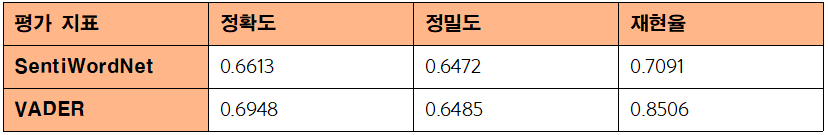
